In [1]:
import os
import json
import csv
import re
from collections import Counter

NONE_LABEL = 'None'

def ensure_exists(path):
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        

def compress_data(
        multi_label_data_path, 
        re_labels_path, 
        output_path,
        none_label=NONE_LABEL
    ):
    label_regexes = []
    with open(re_labels_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            ngram, _, label, group = row
            regex_string = '\\s+'.join(ngram.strip().split(' '))
            regex = re.compile(regex_string, re.IGNORECASE)
            label_regexes.append((group, regex))

    all_labels = list(set([l[0] for l in label_regexes]))
    all_labels.append(none_label)
    labels_path = os.path.join(output_path, 'labels.txt')
    ensure_exists(labels_path)
    with open(labels_path, 'w') as f:
        for l in all_labels:
            f.write(f'{l}\n')
    
    users = Counter()
    subreddits = Counter()
    classes = Counter()
    
    comments = []
    labels = []
    label_index = {l:all_labels.index(l) for l in all_labels}

    with open(multi_label_data_path, 'r') as i, open(os.path.join(output_path, 'comments.csv'), 'w') as o:
        writer = csv.writer(o)
        
        for ct, line in enumerate(i):
            if (ct % 10000) == 0:
                print(f'[Multilabel] Processing comment {ct:,}...')

            data = json.loads(line)
            comment = data['body']
            user = data['author']
            subreddit = data['subreddit']
            _id = data['id']
            label, _ = find_label(comment, label_regexes)                
            if label is None:
                label = none_label
            
            users[user] += 1
            subreddits[subreddit] += 1
            classes[label] += 1
            
            writer.writerow([subreddit, user, label, _id, comment])

        print(f'[Multilabel] Finished reading and labeling {len(labels)} datapoints')
    

    def write_data(counter, file_name):
        print(f'Writing {file_name}')
        with open(os.path.join(output_path, f'{file_name}.csv'), 'w') as f:
            writer = csv.writer(f)
            for k,v in counter.items():
                writer.writerow([k,v])
    
    write_data(users, 'users')
    write_data(subreddits, 'subreddits')
    write_data(classes, 'classes')
    
    print(users.most_common(10))
    print(subreddits.most_common(10))
    print(classes.most_common())
    
        
def find_label(comment, label_regexes):    
    c = Counter()
    for label, regex in label_regexes:
        if regex.search(comment):
            c[label] += 1

    labels = c.most_common(1)
    if len(labels) == 0:
        return None, comment
    else:
        return labels[0][0], comment

# compress_data(
#     multi_label_data_path = 'data/hate_comments.json', 
#     re_labels_path = 'data/refined_ngram_dict_labeled.csv', 
#     output_path = 'data/user_analysis', 
#     )

In [2]:
def read_counter(file_name, output_path = 'data/user_analysis'):
    print(f'Reading {file_name}')
    c = Counter()
    with open(os.path.join(output_path, f'{file_name}.csv'), 'r') as f:
        reader = csv.reader(f)
        for k,v in reader:
            c[k] = int(v)
    
    return c

user_counts = read_counter('users')
subreddit_counts = read_counter('subreddits')
len(user_counts.values())
user_count_numbers = list(user_counts.values())

Reading users
Reading subreddits


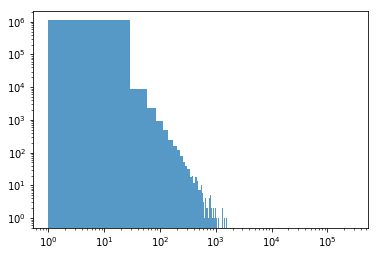

In [12]:
import matplotlib.pyplot as plt
from pylab import rcParams

d = user_count_numbers
n, bins, patches = plt.hist(d, 10000, alpha=0.75)
plt.yscale('log')
plt.xscale('log')
plt.show()
    

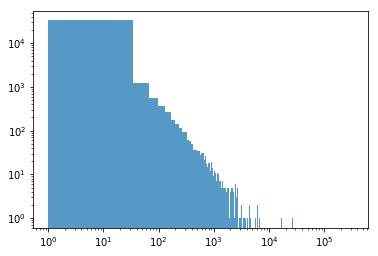

In [17]:
d = list(subreddit_counts.values())
n, bins, patches = plt.hist(d, 10000, alpha=0.75)
plt.yscale('log')
plt.xscale('log')
plt.show()
    

In [19]:
len(user_counts)

1104922

In [3]:
top_users = [u[0] for u in user_counts.most_common(1200)]
top_users = [tu for tu in top_users if '[deleted]' not in tu]
top_users = [tu for tu in top_users if 'mod' not in tu.lower()]
top_users = [tu for tu in top_users if 'bot' not in tu.lower()][:1000]

import random
sample = random.sample(top_users, 100)

In [4]:
print(sample)

['KRosen333', 'PisslamicState', 'LittleBigKid2000', 'HighAngleAlpha0331', 'Aerik', 'RaoulDuke96', 'tom637', 'JasonGD1982', 'throwawawyy2', 'acorsicanpimp', 'SoCalMAGABRO', 'gtVel', 'zenicaone', '_Keemstar_', 'jihad_dildo', 'Bigdickedelf', 'stonepimpletilists', 'zdaytonaroadster', 'GGALLIN1776', 'sempire', 'TriangleDimes', 'Capatown', 'ShitArchonXPR', 'thereisnosuchthing', 'JumbledFun', 'The_Zett', 'WeirdEraCont', 'dakkar1', 'JiggabooShrimp', 'fmlom', 'mach-2', 'DrWoodcock', 'RabidRaccoon', 'datsrhesus', 'thrownaway_MGTOW', 'Electromeatloaf', 'Offensive_Brute', 'KennethFresno', 'freedombonerz', 'HatredsBlazingGun', 'IllimitableMan', 'FaggotBannedKeith', 'Shitty_Rage_Comic', 'hardcorebrowser', 'serialflamingo', 'GiefDownvotesPlox', 'throwaway-o', 'x86_64Ubuntu', 'ItsATedAndRandParty', 'Dudesan', 'thelordofcheese', 'HydrogenAndREDDIT', 'zahlman', 'samsterlicious', 'FhearSliabhNeil', 'maynardsabeast', 'naterc77', 'TipTipTopKek-NE', 'SeanCoonery007', 'Bannedfromfun', 'dolgar', 'Fidena', 'ru

In [6]:
query = 'SELECT * FROM `fh-bigquery.reddit_comments.20*` WHERE\n'
for s in sample:
    query += f'\tUPPER(author) = "{s.upper()}" OR\n'

query = query[:-3]
print(query)
    

SELECT * FROM `fh-bigquery.reddit_comments.20*` WHERE
	UPPER(author) = "KROSEN333" OR
	UPPER(author) = "PISSLAMICSTATE" OR
	UPPER(author) = "LITTLEBIGKID2000" OR
	UPPER(author) = "HIGHANGLEALPHA0331" OR
	UPPER(author) = "AERIK" OR
	UPPER(author) = "RAOULDUKE96" OR
	UPPER(author) = "TOM637" OR
	UPPER(author) = "JASONGD1982" OR
	UPPER(author) = "THROWAWAWYY2" OR
	UPPER(author) = "ACORSICANPIMP" OR
	UPPER(author) = "SOCALMAGABRO" OR
	UPPER(author) = "GTVEL" OR
	UPPER(author) = "ZENICAONE" OR
	UPPER(author) = "_KEEMSTAR_" OR
	UPPER(author) = "JIHAD_DILDO" OR
	UPPER(author) = "BIGDICKEDELF" OR
	UPPER(author) = "STONEPIMPLETILISTS" OR
	UPPER(author) = "ZDAYTONAROADSTER" OR
	UPPER(author) = "GGALLIN1776" OR
	UPPER(author) = "SEMPIRE" OR
	UPPER(author) = "TRIANGLEDIMES" OR
	UPPER(author) = "CAPATOWN" OR
	UPPER(author) = "SHITARCHONXPR" OR
	UPPER(author) = "THEREISNOSUCHTHING" OR
	UPPER(author) = "JUMBLEDFUN" OR
	UPPER(author) = "THE_ZETT" OR
	UPPER(author) = "WEIRDERACONT" OR
	UPPER(author) = 

In [7]:
label_counts = read_counter('classes')


Reading classes


In [24]:
subreddits = [sc[0] for sc in subreddit_counts.most_common(100)]
query = 'SELECT * FROM `fh-bigquery.reddit_comments.20*` WHERE\n'
for s in subreddits:
    query += f'\tsubreddit = "{s}" OR\n'

query = query[:-3]
print(query)
    

SELECT * FROM `fh-bigquery.reddit_comments.20*` WHERE
	subreddit = "AskReddit" OR
	subreddit = "4chan" OR
	subreddit = "funny" OR
	subreddit = "pics" OR
	subreddit = "politics" OR
	subreddit = "videos" OR
	subreddit = "WTF" OR
	subreddit = "todayilearned" OR
	subreddit = "opieandanthony" OR
	subreddit = "The_Donald" OR
	subreddit = "CoonTown" OR
	subreddit = "CringeAnarchy" OR
	subreddit = "ImGoingToHellForThis" OR
	subreddit = "worldnews" OR
	subreddit = "AdviceAnimals" OR
	subreddit = "news" OR
	subreddit = "4chan4trump" OR
	subreddit = "atheism" OR
	subreddit = "gaming" OR
	subreddit = "TumblrInAction" OR
	subreddit = "DotA2" OR
	subreddit = "wallstreetbets" OR
	subreddit = "reddit.com" OR
	subreddit = "KotakuInAction" OR
	subreddit = "SubredditDrama" OR
	subreddit = "IAmA" OR
	subreddit = "milliondollarextreme" OR
	subreddit = "Ice_Poseidon" OR
	subreddit = "starcraft" OR
	subreddit = "changemyview" OR
	subreddit = "leagueoflegends" OR
	subreddit = "dankmemes" OR
	subreddit = "Dram

In [77]:
labeled_user_comments_path = 'data/user_analysis/100_users_comments_labeled.json'
# labeled_user_comments_path = 'labeled_100_subreddit_comments.json'
counters = {}
with open(labeled_user_comments_path, 'r') as f:
    for line in f:
        data = json.loads(line)
        user = data['author']
        label = data['label']
        counters.setdefault(user, Counter())
        counters[user][label] += 1

In [78]:
ratios = {}
distributions = {}
# labels = ['None', 'Rage', 'Racism', 'Homophobia']
for u, c in counters.items():
    total_comments = float(sum(c.values()))
    r = {}
    for k, v in c.items():
        distributions.setdefault(k, [])
        r[k] = v/total_comments
        distributions[k].append(v/total_comments)
        
    ratios[u] = r



0
1
2
3


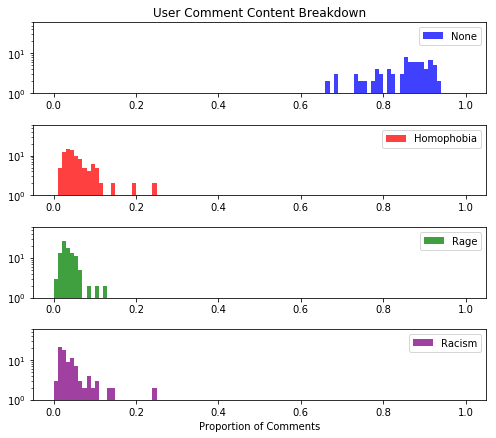

In [82]:
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.mlab as mlab
from scipy.stats import norm, gamma, poisson
rcParams['font.size'] = 10
rcParams['figure.figsize'] = 7,6
colors = ('blue', 'red', 'green', 'purple')
# fig, axes = plt.subplots(ncols=2, nrows=2)
for i, (k, d) in enumerate(distributions.items()):
    print(i)
    plt.subplot(4, 1, i+1)
    if i == 0:
        plt.title('User Comment Content Breakdown')
    n, bins, patches = plt.hist(d, 100, range=(0,1), label=k, alpha=0.75, color=colors[i])
    ag,bg,cg = gamma.fit(d)
    lnspc = np.linspace(0,1, 100)
    pdf_gamma = gamma.pdf(lnspc, ag, bg,cg)  
    axes = plt.gca()
    plt.yscale('log')
    axes.set_ylim([0, 60])
#     y = mlab.normpdf( bins, mu, sigma)
#     plt.plot(lnspc, pdf_gamma, 'r--', linewidth=1)
    plt.legend()

plt.tight_layout()
plt.xlabel('Proportion of Comments')
plt.show()

In [ ]:
N = len(ratios)
ind = np.arange(N)


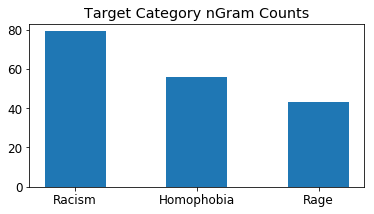

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 6,3
rcParams['font.size'] = 12

l = Counter()
g = Counter()
with open('data/refined_ngram_dict_labeled.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        _, _, label, group = row
        l[label] += 1
        g[group] += 1

fig, ax = plt.subplots()
groups = list(g.keys())
bar_width = 0.5
counts = [g[i] for i in groups]
ax.bar(np.arange(len(groups)), counts, bar_width, align='center')
ax.set_xticks(np.arange(len(groups)))
ax.set_xticklabels(groups)
plt.xticks(rotation=0)
plt.title('Target Category nGram Counts')
plt.show()


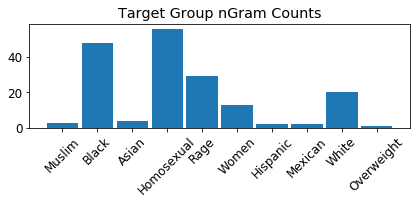

In [45]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 10,5
# rcParams['font.size'] = 10

l = Counter()
g = Counter()
with open('data/refined_ngram_dict_labeled.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        _, _, label, group = row
        l[label] += 1
        g[group] += 1

fig, ax = plt.subplots()
groups = list(i.strip() for i in l.keys())
bar_width = 0.9
counts = [l[i] for i in groups]
ax.bar(np.arange(len(groups)), counts, bar_width, align='center')
ax.set_xticks(np.arange(len(groups)))
ax.set_xticklabels(groups)
plt.title('Target Group nGram Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()